In [ ]:
# default_exp wbs

# WBS

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import cv2
import numpy as np
import abc
from copy import deepcopy
from pathlib import Path
from typing import List, Tuple
class LocalFeatureExtractor():
    def __init__(self, **kwargs):
        '''In'''
        return
    @abc.abstractmethod
    def detect(self, image: np.array, mask:np.array) -> List[cv2.KeyPoint]:
        return
    @abc.abstractmethod
    def compute(self, image: np.array, keypoints = None) -> Tuple[List[cv2.KeyPoint], np.array]:
        return
    
#export
class DescriptorMatcher():
    def __init__(self, **kwargs):
        '''In'''
        return
    @abc.abstractmethod
    def match(self, queryDescriptors:np.array, trainDescriptors:np.array) -> List[cv2.DMatch]:
        out = []
        return out
#export 
class GeometricVerifier():
    def __init__(self, **kwargs):
        '''In'''
        return
    @abc.abstractmethod
    def verify(self, srcPts:np.array, dstPts:np.array):
        out = []
        return F, mask

In [ ]:
#export
class RootSIFT(LocalFeatureExtractor):
    def __init__(self, **kwargs):
        self.desc = cv2.SIFT_create(8000)
        '''In'''
        return
    def compute(self, image: np.array, keypoints = None) -> Tuple[List[cv2.KeyPoint], np.array]:
        kps, descs  = self.desc.compute(image, keypoints)
        descs /= descs.sum(axis=1, keepdims=True) + 1e-8
        descs = np.sqrt(descs)
        return kps, descs

In [ ]:
#export
class HardNetDesc(LocalFeatureExtractor):
    def __init__(self, **kwargs):
        import kornia.feature as KF
        from extract_patches.core import extract_patches
        self.model = KF.HardNet(True).eval()
        '''In'''
        return
    def compute(self, image: np.array, keypoints = None) -> Tuple[List[cv2.KeyPoint], np.array]:
        patches = extract_patches(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), keypoints, 32, 12.0)
        model = self.model.cuda()
        torch_patches = torch.from_numpy(np.stack(patches, axis=0)).float().cuda()
        out_desc = np.zeros((len(torch_patches), 128))
        bs = 128
        for i in range(0, len(patches), bs):
            data_a = torch_patches[i: i + bs, :, :, :]
            with torch.no_grad():
                out_a = model(data_a)
            out_desc[i: i + bs,:] = out_a.data.cpu().numpy().reshape(-1, 128)
        return kps, out_desc

In [ ]:
#export
class SNNMatcher():
    def __init__(self, th = 0.8):
        '''In'''
        self.th = th 
        return
    @abc.abstractmethod
    def match(self, queryDescriptors:np.array, trainDescriptors:np.array) -> List[cv2.DMatch]:
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
        matches = matcher.knnMatch(queryDescriptors, trainDescriptors, 2)
        good_matches = []
        for m in matches:
            if m[0].distance / (1e-8 + m[1].distance) <= self.th :
                good_matches.append(m[0])
        return good_matches

In [ ]:
#export
class SNNMMatcher():
    def __init__(self, th = 0.9):
        '''In'''
        self.th = th 
        return
    def match(self, queryDescriptors:np.array, trainDescriptors:np.array) -> List[cv2.DMatch]:
        import kornia.feature as KF
        import torch
        dists, idxs = KF.match_smnn(torch.from_numpy(queryDescriptors).float().cuda(),
                                   torch.from_numpy(trainDescriptors).float().cuda(),
                                   self.th)
        good_matches = []
        for idx_q_t in idxs.detach().cpu().numpy():
            good_matches.append(cv2.DMatch(idx_q_t[0].item(), idx_q_t[1].item(), 0))
        return good_matches

In [ ]:
#export
class CV2_RANSACVerifier(GeometricVerifier):
    def __init__(self, th = 0.5):
        self.th = th
        return
    def verify(self, srcPts:np.array, dstPts:np.array):
        F, mask = cv2.findFundamentalMat(srcPts, dstPts, cv2.RANSAC, self.th)
        return F, mask

In [ ]:
#export
class TwoViewMatcher():
    def __init__(self, detector:LocalFeatureExtractor = cv2.SIFT_create(8000),
                       descriptor:LocalFeatureExtractor = cv2.SIFT_create(8000),
                       matcher: DescriptorMatcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED),
                       geom_verif: GeometricVerifier = CV2_RANSACVerifier(0.5)):
        self.det = detector
        self.desc = descriptor
        self.matcher = matcher
        self.geom_verif = geom_verif
        return
    def verify(self, img1_fname, img2_fname):
        if type(img1_fname) is str:
            img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
        else:
            img1 = img1_fname
        if type(img2_fname) is str:
            img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)
        else:
            img2 = img2_fname
        
        
        kps1 = self.det.detect(img1, None)
        kps1, descs1 = self.det.compute(img1,  kps1)
        
        kps2 = self.det.detect(img2, None)
        kps2, descs2 = self.det.compute(img2, kps2)
        
        tentative_matches = self.matcher.match(descs1, descs2)
        
        src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentative_matches]).reshape(-1,2)
        dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentative_matches]).reshape(-1,2)
    
        F, mask = self.geom_verif.verify(src_pts, dst_pts)
        
        good_kpts1 = [ kps1[m.queryIdx] for i,m in enumerate(tentative_matches) if mask[i]]
        good_kpts2 = [ kps2[m.trainIdx] for i,m in enumerate(tentative_matches) if mask[i]]
        result = {'match_kpts1': good_kpts1, 
                  'match_kpts2': good_kpts2,
                  'F': F,
                  'num_inl': len(good_kpts1)}
        return result

In [ ]:
#export
import pydegensac
class degensac_Verifier(GeometricVerifier):
    def __init__(self, th = 0.5):
        self.th = th
        return
    def verify(self, srcPts:np.array, dstPts:np.array):
        F, mask = pydegensac.findFundamentalMatrix(srcPts, dstPts, self.th, 0.999, max_iters=250000)
        return F, mask

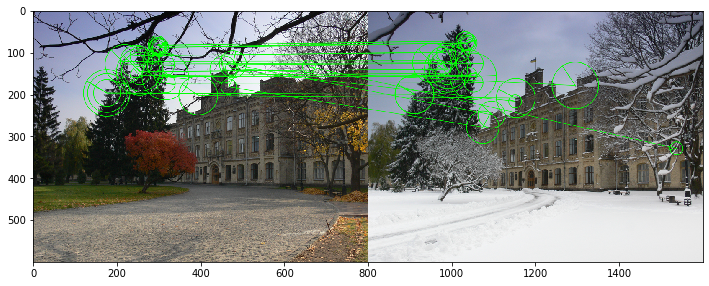

In [ ]:
from local_feature_tutorial.visualization import *
wbs = TwoViewMatcher(detector = cv2.ORB_create(1500),
                     descriptor = cv2.ORB_create(1500),
                     matcher=cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING),
        geom_verif=CV2_RANSACVerifier())
res = wbs.verify('data/kpi/01.png', 
                 'data/kpi/02.png')

draw_matches_cv2(res['match_kpts1'], res['match_kpts2'],
                'data/kpi/01.png', 
                'data/kpi/02.png')

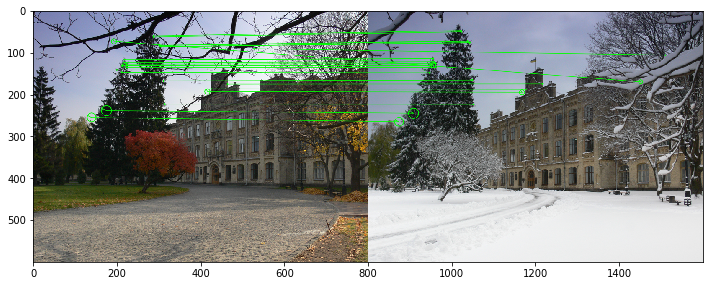

In [ ]:
from local_feature_tutorial.visualization import *
wbs = TwoViewMatcher(detector = cv2.SIFT_create(1500),
                     descriptor = HardNetDesc(),
                     matcher=SNNMMatcher(0.9),
        geom_verif=degensac_Verifier())
res = wbs.verify('data/kpi/01.png', 
                 'data/kpi/02.png')

draw_matches_cv2(res['match_kpts1'], res['match_kpts2'],
                'data/kpi/01.png', 
                'data/kpi/02.png')

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted datasets.ipynb.
Converted index.ipynb.
Converted io.ipynb.
Converted retrieval.ipynb.
Converted visualization.ipynb.
Converted wbs.ipynb.
